In [2]:
import pydicom as dcm
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import pytesseract
import imutils
import cv2
import re
import requests
from urllib import request
from PIL import Image


def remove_last_dot(input_string):
    last_dot_index = input_string.rfind(".")
    
    # 맨 마지막에 마침표가 있을 경우 제거
    if last_dot_index != -1 and last_dot_index == len(input_string) - 1:
        cleaned_string = input_string[:last_dot_index]
    else:
        cleaned_string = input_string
    
    return cleaned_string

def extract_text_from_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)

    word_list = text.split('\n')
    idx = 0
    for i in range(len(word_list)):
        if len(word_list[i]) > 0:
            word_list[idx] = remove_last_dot(word_list[i])
            idx += 1
    
    return word_list[:idx]

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()



def extract_bar(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
    image_list_title = []
    image_list = []
 
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
 
    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리를 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
 
    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
    findCnt = None
 
    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)
 
        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) == 4:
            findCnt = approx
            break
 
    # 만약 추출한 윤곽이 없을 경우 오류
    if findCnt is None:
        raise Exception(("Could not find outline."))
 
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
    image_list_title.append("Outline")
    image_list.append(output)
 
    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

    # 추출한 직사각형 부분만 ROI로 잘라내어 반환
    roi = four_point_transform(image, findCnt.reshape(4, 2))
    
    # 원본 이미지와 스캔된 이미지를 함께 표시
    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform", transform_image)

    return roi


def make_roi(x, y, w, h, dcm_sample, window_name):
    roi = dcm_sample[y:y+h, x:x+w]
    dcm_sample[y:y+h, x:x+w] = roi
    return roi

def extract_pixel_data_dict(threshold, bar_image, max_value, min_value):
    height = bar_image.shape[0]
    bar_height = float(max_value) - float(min_value)
    val = round(bar_height / (254), 3)
    weight = float(max_value)
    pixel_data_dict = {}

    for y in range(254):
        x = bar_image.shape[1] // 2
        pixel_height = y
        bar_bgr = tuple(dcm_sample[129+y, 501])  # BGR 값을 튜플로 변환
        pixel_data_dict[bar_bgr] = round(weight, 3)
        weight = weight - val
        print({"BGR" : bar_bgr, "weight" : pixel_data_dict[bar_bgr]})
    return pixel_data_dict

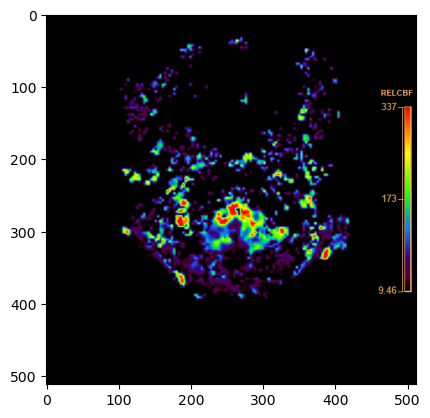

RELCBF 337 173 9.46


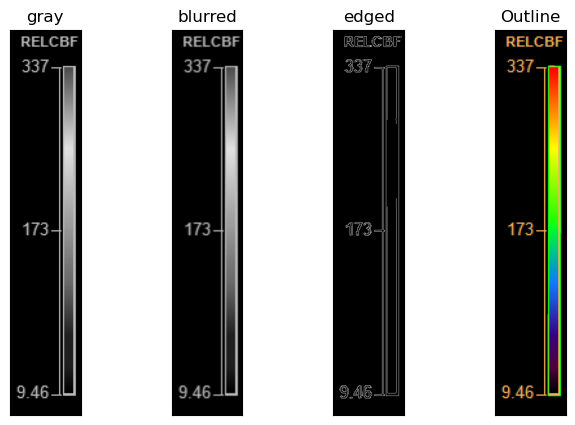

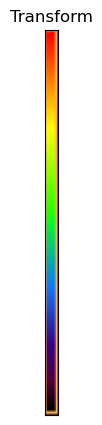

{'BGR': (0, 0, 255), 'weight': 337.0}
{'BGR': (0, 4, 255), 'weight': 335.71}
{'BGR': (0, 8, 255), 'weight': 334.42}
{'BGR': (0, 12, 255), 'weight': 333.13}
{'BGR': (0, 16, 255), 'weight': 331.84}
{'BGR': (0, 20, 255), 'weight': 330.55}
{'BGR': (0, 24, 255), 'weight': 329.26}
{'BGR': (0, 28, 255), 'weight': 327.97}
{'BGR': (0, 32, 255), 'weight': 326.68}
{'BGR': (0, 36, 255), 'weight': 325.39}
{'BGR': (0, 40, 255), 'weight': 324.1}
{'BGR': (0, 44, 255), 'weight': 322.81}
{'BGR': (0, 48, 255), 'weight': 321.52}
{'BGR': (0, 52, 255), 'weight': 320.23}
{'BGR': (0, 56, 255), 'weight': 318.94}
{'BGR': (0, 60, 255), 'weight': 317.65}
{'BGR': (0, 65, 255), 'weight': 316.36}
{'BGR': (0, 69, 255), 'weight': 315.07}
{'BGR': (0, 73, 255), 'weight': 313.78}
{'BGR': (0, 77, 255), 'weight': 312.49}
{'BGR': (0, 81, 255), 'weight': 311.2}
{'BGR': (0, 85, 255), 'weight': 309.91}
{'BGR': (0, 89, 255), 'weight': 308.62}
{'BGR': (0, 93, 255), 'weight': 307.33}
{'BGR': (0, 97, 255), 'weight': 306.04}
{'BGR'

In [2]:
# path = "/Users/isacc_kim/Desktop/PWI/20230807 PWI source example 2/230802(5870)/MTT/MTT0000.dcm"
# path = "/Users/isacc_kim/Desktop/PWI/20230807 PWI source example 2/230802(5870)/TTP/TTP0000.dcm"
path = "/Users/isacc_kim/Desktop/PWI/20230807 PWI source example 2/230802(5870)/CBF/CBF0001.dcm"


ds = dcm.dcmread(path)

plt.imshow(ds.pixel_array,cmap='gray')
plt.show()


# save pixel data for Opencv 
dcm_sample=ds.pixel_array
dcm_sample = cv2.cvtColor(dcm_sample, cv2.COLOR_RGB2BGR)

#roi for bar
x=455; y=100; w=55; h=300
bar_roi = make_roi(x, y, w, h, dcm_sample, window_name="test_bar")

gray = cv2.cvtColor(bar_roi, cv2.COLOR_BGR2GRAY) 

text = pytesseract.image_to_string(gray)

word_list = extract_text_from_roi(bar_roi)


unit = word_list[0]
max = word_list[1]
mid = word_list[2]
min = word_list[3]

print(unit,max,mid,min)

bar_image = extract_bar(bar_roi, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)


threshold = 3

pixel_data_dict = extract_pixel_data_dict(threshold, bar_image, max,min)

#ROI for detect brain image

x=0; y=0; w=457; h=512

brain_roi = make_roi(x, y, w, h, dcm_sample, window_name="test_brain")

In [58]:
total_weight = 0.0
fail = 0 
error = 0
for h in range(brain_roi.shape[0]):  # 높이에 대한 루프
    for w in range(brain_roi.shape[1]):  # 너비에 대한 루프
        bgr_value = tuple(brain_roi[h, w])  # 현재 위치의 BGR 값을 가져와 튜플로 변환
        if bgr_value in pixel_data_dict:
            match = match+1
            total_weight += pixel_data_dict[bgr_value]
        if not bgr_value in pixel_data_dict:
            fail = fail+1

error = fail /  (brain_roi.shape[0] * brain_roi.shape[1])
total_weight = round(total_weight,2)

print({"result" :  total_weight})
print({"fail to match" :  round(error,5)})

{'result': 2919166.41}
{'fail to match': 0.12591}
